# 链式法则与反向传播直觉

## 用最简单的两层网络理解：梯度如何一步步降低 Loss

我们用一个只有 **标量** 的两层网络，把正向传播、链式法则、反向传播、梯度下降的每一步都「看得见、摸得着」。

## 网络结构

```
x → [h = w1·x + b1] → h → [ŷ = w2·h + b2] → ŷ → Loss = (ŷ - y)²
      第一层(隐藏层)           第二层(输出层)          损失函数
```

为了把注意力完全放在**链式法则**上，我们先把 b1=0, b2=0，用最干净的形式：

```
h = w1 · x
ŷ = w2 · h
Loss = (ŷ - y)²
```

In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib

# 设置中文字体（macOS）
matplotlib.rcParams['font.family'] = ['Arial Unicode MS', 'Heiti TC', 'sans-serif']
matplotlib.rcParams['axes.unicode_minus'] = False

/Users/bytedance/venv/lib/python3.13/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


---
## 第一步：正向传播 (Forward Pass)

给定输入 x 和目标 y，**从左到右**逐层计算，最终得到 Loss。

In [2]:
# ============================================================
# 定义初始值 —— 和 ChatGPT 对话中相同的数字
# ============================================================
x  = 2.0   # 输入
y  = 10.0  # 目标值（我们希望网络输出接近 y）
w1 = 3.0   # 第一层权重
w2 = 4.0   # 第二层权重

# ============================================================
# 正向传播：从左到右，逐步计算
# ============================================================
h     = w1 * x          # 第一层输出（隐藏层）
y_hat = w2 * h           # 第二层输出（预测值）
loss  = (y_hat - y) ** 2 # 损失函数：预测值与目标的差的平方

print("========== 正向传播 (Forward Pass) ==========")
print(f"输入:  x = {x}")
print(f"目标:  y = {y}")
print(f"权重:  w1 = {w1}, w2 = {w2}")
print()
print(f"第一层:  h = w1 · x = {w1} × {x} = {h}")
print(f"第二层:  ŷ = w2 · h = {w2} × {h} = {y_hat}")
print(f"损失:    Loss = (ŷ - y)² = ({y_hat} - {y})² = {y_hat - y}² = {loss}")
print()
print(f"💡 预测值 ŷ={y_hat} 离目标 y={y} 差很远，Loss={loss} 很大！")
print(f"   我们需要调整 w1 和 w2 来让 Loss 变小。")
print(f"   问题是：w1 和 w2 各该往哪个方向调？调多少？")
print(f"   → 这就是反向传播要回答的问题！")

========== 正向传播 (Forward Pass) ==========
输入:  x = 2.0
目标:  y = 10.0
权重:  w1 = 3.0, w2 = 4.0

第一层:  h = w1 · x = 3.0 × 2.0 = 6.0
第二层:  ŷ = w2 · h = 4.0 × 6.0 = 24.0
损失:    Loss = (ŷ - y)² = (24.0 - 10.0)² = 14.0² = 196.0

💡 预测值 ŷ=24.0 离目标 y=10.0 差很远，Loss=196.0 很大！
   我们需要调整 w1 和 w2 来让 Loss 变小。
   问题是：w1 和 w2 各该往哪个方向调？调多少？
   → 这就是反向传播要回答的问题！


---
## 第二步：链式法则 (Chain Rule) —— 反向传播的数学基础

**核心问题**：Loss 对每个权重的偏导数是多少？即 ∂Loss/∂w1 和 ∂Loss/∂w2。

**难点**：w1 并不直接出现在 Loss 公式里，它通过 h → ŷ → Loss 间接影响 Loss。

**链式法则**就是解决这个问题的工具 —— 把间接的影响拆成一连串直接的影响，逐步相乘：

$$\frac{\partial \text{Loss}}{\partial w_1} = \frac{\partial \text{Loss}}{\partial \hat{y}} \times \frac{\partial \hat{y}}{\partial h} \times \frac{\partial h}{\partial w_1}$$

每一项都是「相邻两个变量之间的局部导数」，只需要知道当前这一层的公式就能算出来。

In [3]:
# ============================================================
# 链式法则：从后往前，逐步计算每个节点的梯度
# ============================================================

# --- 第 1 环：Loss 对 ŷ 的导数 ---
# Loss = (ŷ - y)²
# ∂Loss/∂ŷ = 2(ŷ - y)   （幂函数求导）
dL_dy_hat = 2 * (y_hat - y)
print("========== 链式法则：逐环计算梯度 ==========")
print(f"第 1 环: ∂Loss/∂ŷ = 2(ŷ - y) = 2×({y_hat}-{y}) = {dL_dy_hat}")
print()

# --- 第 2 环：ŷ 对 w2 的导数 → 得到 ∂Loss/∂w2 ---
# ŷ = w2 · h，所以 ∂ŷ/∂w2 = h
dy_hat_dw2 = h
dL_dw2 = dL_dy_hat * dy_hat_dw2  # 链式法则！
print(f"第 2 环: ∂ŷ/∂w2 = h = {h}")
print(f"  链式法则 → ∂Loss/∂w2 = ∂Loss/∂ŷ × ∂ŷ/∂w2 = {dL_dy_hat} × {h} = {dL_dw2}")
print()

# --- 第 3 环：ŷ 对 h 的导数 → 得到 ∂Loss/∂h ---
# ŷ = w2 · h，所以 ∂ŷ/∂h = w2
dy_hat_dh = w2
dL_dh = dL_dy_hat * dy_hat_dh     # 链式法则！
print(f"第 3 环: ∂ŷ/∂h = w2 = {w2}")
print(f"  链式法则 → ∂Loss/∂h = ∂Loss/∂ŷ × ∂ŷ/∂h = {dL_dy_hat} × {w2} = {dL_dh}")
print()

# --- 第 4 环：h 对 w1 的导数 → 得到 ∂Loss/∂w1 ---
# h = w1 · x，所以 ∂h/∂w1 = x
dh_dw1 = x
dL_dw1 = dL_dh * dh_dw1           # 链式法则！
print(f"第 4 环: ∂h/∂w1 = x = {x}")
print(f"  链式法则 → ∂Loss/∂w1 = ∂Loss/∂h × ∂h/∂w1 = {dL_dh} × {x} = {dL_dw1}")
print()

print("========== 汇总 ==========")
print(f"∂Loss/∂w2 = {dL_dw2}  （w2 每增加 1，Loss 大约增加 {dL_dw2}）")
print(f"∂Loss/∂w1 = {dL_dw1}  （w1 每增加 1，Loss 大约增加 {dL_dw1}）")
print()
print("💡 梯度为正 → 权重增大会让 Loss 增大 → 所以应该减小权重！")
print("   这就是梯度下降的方向。")

========== 链式法则：逐环计算梯度 ==========
第 1 环: ∂Loss/∂ŷ = 2(ŷ - y) = 2×(24.0-10.0) = 28.0

第 2 环: ∂ŷ/∂w2 = h = 6.0
  链式法则 → ∂Loss/∂w2 = ∂Loss/∂ŷ × ∂ŷ/∂w2 = 28.0 × 6.0 = 168.0

第 3 环: ∂ŷ/∂h = w2 = 4.0
  链式法则 → ∂Loss/∂h = ∂Loss/∂ŷ × ∂ŷ/∂h = 28.0 × 4.0 = 112.0

第 4 环: ∂h/∂w1 = x = 2.0
  链式法则 → ∂Loss/∂w1 = ∂Loss/∂h × ∂h/∂w1 = 112.0 × 2.0 = 224.0

========== 汇总 ==========
∂Loss/∂w2 = 168.0  （w2 每增加 1，Loss 大约增加 168.0）
∂Loss/∂w1 = 224.0  （w1 每增加 1，Loss 大约增加 224.0）

💡 梯度为正 → 权重增大会让 Loss 增大 → 所以应该减小权重！
   这就是梯度下降的方向。


---
## 可视化：计算图中的正向传播与反向传播

上面一行是**正向传播**（蓝色，从左到右计算值），下面一行是**反向传播**（红色，从右到左传递梯度）。

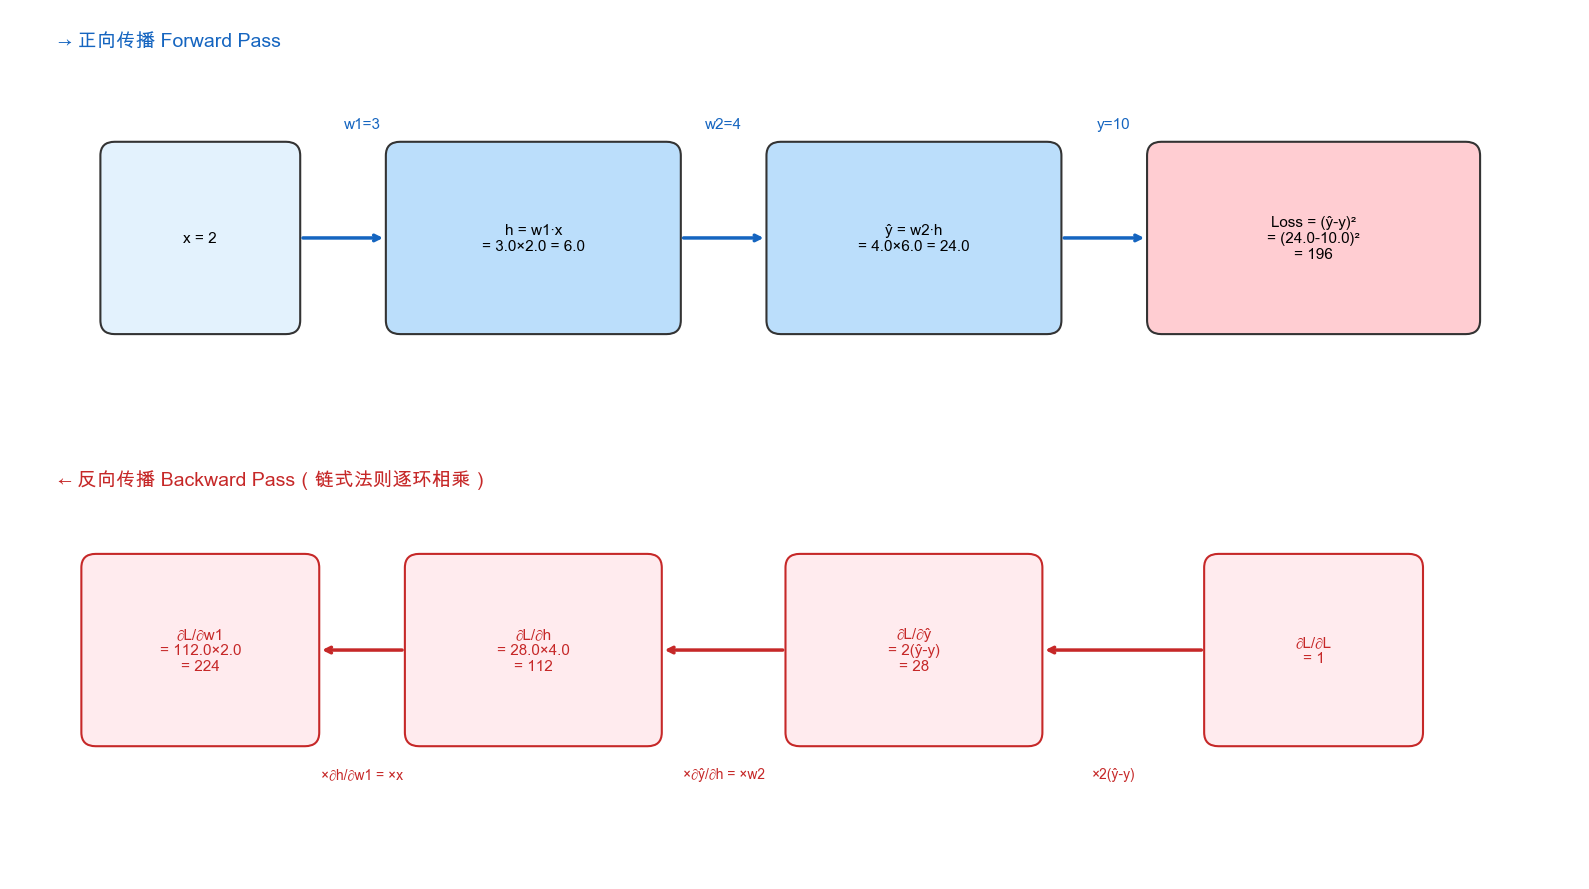

In [4]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_xlim(-0.5, 16)
ax.set_ylim(-0.5, 9)
ax.axis('off')

# ============================================================
# 正向传播节点（上方，蓝色系）
# ============================================================
fwd_nodes = [
    (1.5,  6.5, 'x = 2',                         '#E3F2FD', 1.8),
    (5.0,  6.5, f'h = w1·x\n= {w1}×{x} = {h}',  '#BBDEFB', 2.8),
    (9.0,  6.5, f'ŷ = w2·h\n= {w2}×{h} = {y_hat}', '#BBDEFB', 2.8),
    (13.2, 6.5, f'Loss = (ŷ-y)²\n= ({y_hat}-{y})²\n= {loss:.0f}', '#FFCDD2', 3.2),
]
box_h = 1.8

for cx, cy, text, color, bw in fwd_nodes:
    rect = patches.FancyBboxPatch(
        (cx - bw/2, cy - box_h/2), bw, box_h,
        boxstyle='round,pad=0.15', facecolor=color, edgecolor='#333', linewidth=1.5)
    ax.add_patch(rect)
    ax.text(cx, cy, text, ha='center', va='center', fontsize=11, fontweight='bold')

# 正向箭头
fwd_arrow = dict(arrowstyle='->', color='#1565C0', lw=2.5)
ax.annotate('', xy=(5.0-1.4-0.15, 6.5),  xytext=(1.5+0.9+0.15, 6.5),  arrowprops=fwd_arrow)
ax.annotate('', xy=(9.0-1.4-0.15, 6.5),  xytext=(5.0+1.4+0.15, 6.5),  arrowprops=fwd_arrow)
ax.annotate('', xy=(13.2-1.6-0.15, 6.5), xytext=(9.0+1.4+0.15, 6.5),  arrowprops=fwd_arrow)

# 正向箭头上的标注
ax.text(3.2, 7.7, 'w1=3', fontsize=11, color='#1565C0', ha='center', fontstyle='italic')
ax.text(7.0, 7.7, 'w2=4', fontsize=11, color='#1565C0', ha='center', fontstyle='italic')
ax.text(11.1, 7.7, 'y=10', fontsize=11, color='#1565C0', ha='center', fontstyle='italic')

# ============================================================
# 反向传播节点（下方，红色系）
# ============================================================
bwd_nodes = [
    (1.5,  2.0, f'∂L/∂w1\n= {dL_dh}×{x}\n= {dL_dw1:.0f}',      '#FFEBEE', 2.2),
    (5.0,  2.0, f'∂L/∂h\n= {dL_dy_hat}×{w2}\n= {dL_dh:.0f}',    '#FFEBEE', 2.4),
    (9.0,  2.0, f'∂L/∂ŷ\n= 2(ŷ-y)\n= {dL_dy_hat:.0f}',         '#FFEBEE', 2.4),
    (13.2, 2.0, '∂L/∂L\n= 1',                                     '#FFEBEE', 2.0),
]

for cx, cy, text, color, bw in bwd_nodes:
    rect = patches.FancyBboxPatch(
        (cx - bw/2, cy - box_h/2), bw, box_h,
        boxstyle='round,pad=0.15', facecolor=color, edgecolor='#C62828', linewidth=1.5)
    ax.add_patch(rect)
    ax.text(cx, cy, text, ha='center', va='center', fontsize=11, color='#C62828', fontweight='bold')

# 反向箭头（从右到左）
bwd_arrow = dict(arrowstyle='->', color='#C62828', lw=2.5)
ax.annotate('', xy=(9.0+1.2+0.15, 2.0),  xytext=(13.2-1.0-0.15, 2.0), arrowprops=bwd_arrow)
ax.annotate('', xy=(5.0+1.2+0.15, 2.0),  xytext=(9.0-1.2-0.15, 2.0),  arrowprops=bwd_arrow)
ax.annotate('', xy=(1.5+1.1+0.15, 2.0),  xytext=(5.0-1.2-0.15, 2.0),  arrowprops=bwd_arrow)

# 反向箭头上的标注（局部导数）
ax.text(11.1, 0.6, '×2(ŷ-y)', fontsize=10, color='#C62828', ha='center', fontstyle='italic')
ax.text(7.0,  0.6, '×∂ŷ/∂h = ×w2', fontsize=10, color='#C62828', ha='center', fontstyle='italic')
ax.text(3.2,  0.6, '×∂h/∂w1 = ×x', fontsize=10, color='#C62828', ha='center', fontstyle='italic')

# 标题
ax.text(0, 8.6, '→ 正向传播 Forward Pass', fontsize=14, color='#1565C0', fontweight='bold')
ax.text(0, 3.8, '← 反向传播 Backward Pass（链式法则逐环相乘）', fontsize=14, color='#C62828', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 第三步：梯度下降 —— 用梯度更新权重，让 Loss 变小

梯度告诉我们「往哪个方向调权重会让 Loss 增大」，那我们就**往反方向调**：

$$w_{\text{new}} = w_{\text{old}} - \text{lr} \times \frac{\partial \text{Loss}}{\partial w}$$

其中 lr (learning rate) 是学习率，控制每步调整的幅度。

In [5]:
# ============================================================
# 梯度下降：用梯度更新权重，观察 Loss 的变化
# ============================================================
lr = 0.001  # 学习率（因为梯度值较大，用小一点的 lr）

print("========== 梯度下降：一步更新 ==========")
print(f"学习率 lr = {lr}")
print()

# 更新 w1
w1_new = w1 - lr * dL_dw1
print(f"w1: {w1} - {lr} × {dL_dw1} = {w1_new:.4f}  （减小了，因为梯度为正）")

# 更新 w2
w2_new = w2 - lr * dL_dw2
print(f"w2: {w2} - {lr} × {dL_dw2} = {w2_new:.4f}  （减小了，因为梯度为正）")
print()

# 用新权重重新做一次正向传播
h_new     = w1_new * x
y_hat_new = w2_new * h_new
loss_new  = (y_hat_new - y) ** 2

print("--- 用新权重重新正向传播 ---")
print(f"h = {w1_new:.4f} × {x} = {h_new:.4f}")
print(f"ŷ = {w2_new:.4f} × {h_new:.4f} = {y_hat_new:.4f}")
print(f"Loss = ({y_hat_new:.4f} - {y})² = {loss_new:.2f}")
print()
print(f"✅ Loss: {loss:.0f} → {loss_new:.2f}  下降了 {loss - loss_new:.2f}！")
print(f"   仅仅一步梯度下降，Loss 就从 {loss:.0f} 降到了 {loss_new:.2f}。")
print(f"   重复这个过程，Loss 会持续下降，直到预测值 ŷ ≈ y。")

========== 梯度下降：一步更新 ==========
学习率 lr = 0.001

w1: 3.0 - 0.001 × 224.0 = 2.7760  （减小了，因为梯度为正）
w2: 4.0 - 0.001 × 168.0 = 3.8320  （减小了，因为梯度为正）

--- 用新权重重新正向传播 ---
h = 2.7760 × 2.0 = 5.5520
ŷ = 3.8320 × 5.5520 = 21.2753
Loss = (21.2753 - 10.0)² = 127.13

✅ Loss: 196 → 127.13  下降了 68.87！
   仅仅一步梯度下降，Loss 就从 196 降到了 127.13。
   重复这个过程，Loss 会持续下降，直到预测值 ŷ ≈ y。


---
## 第四步：完整训练循环 —— 重复「正向→反向→更新」

把上面三步放进循环，反复执行，观察 Loss 如何持续下降、权重如何逐步调整。

In [6]:
# ============================================================
# 完整训练循环
# ============================================================
x, y = 2.0, 10.0       # 输入和目标
w1, w2 = 3.0, 4.0      # 重置权重到初始值
lr = 0.001              # 学习率
n_steps = 80            # 训练步数

# 记录每一步的值，用于后续可视化
history = {'loss': [], 'w1': [], 'w2': [], 'y_hat': []}

for step in range(n_steps):
    # --- 正向传播 ---
    h     = w1 * x
    y_hat = w2 * h
    loss  = (y_hat - y) ** 2

    # 记录
    history['loss'].append(loss)
    history['w1'].append(w1)
    history['w2'].append(w2)
    history['y_hat'].append(y_hat)

    # --- 反向传播（链式法则） ---
    dL_dy_hat = 2 * (y_hat - y)     # ∂Loss/∂ŷ
    dL_dw2    = dL_dy_hat * h       # ∂Loss/∂w2 = ∂Loss/∂ŷ × ∂ŷ/∂w2
    dL_dh     = dL_dy_hat * w2      # ∂Loss/∂h  = ∂Loss/∂ŷ × ∂ŷ/∂h
    dL_dw1    = dL_dh * x           # ∂Loss/∂w1 = ∂Loss/∂h  × ∂h/∂w1

    # --- 梯度下降 ---
    w1 = w1 - lr * dL_dw1
    w2 = w2 - lr * dL_dw2

    # 每隔 10 步打印一次
    if step % 10 == 0 or step == n_steps - 1:
        print(f"Step {step:3d} | Loss = {loss:8.2f} | ŷ = {y_hat:7.3f} | w1 = {w1:.4f}, w2 = {w2:.4f}")

print(f"\n🎯 训练完成！ŷ = {history['y_hat'][-1]:.3f}，已经非常接近目标 y = {y}")

Step   0 | Loss =   196.00 | ŷ =  24.000 | w1 = 2.7760, w2 = 3.8320
Step  10 | Loss =     8.33 | ŷ =  12.885 | w1 = 1.9242, w2 = 3.2609
Step  20 | Loss =     0.83 | ŷ =  10.909 | w1 = 1.7199, w2 = 3.1441
Step  30 | Loss =     0.10 | ŷ =  10.313 | w1 = 1.6539, w2 = 3.1084
Step  40 | Loss =     0.01 | ŷ =  10.111 | w1 = 1.6310, w2 = 3.0963
Step  50 | Loss =     0.00 | ŷ =  10.040 | w1 = 1.6228, w2 = 3.0920
Step  60 | Loss =     0.00 | ŷ =  10.014 | w1 = 1.6199, w2 = 3.0905
Step  70 | Loss =     0.00 | ŷ =  10.005 | w1 = 1.6189, w2 = 3.0900
Step  79 | Loss =     0.00 | ŷ =  10.002 | w1 = 1.6185, w2 = 3.0898

🎯 训练完成！ŷ = 10.002，已经非常接近目标 y = 10.0


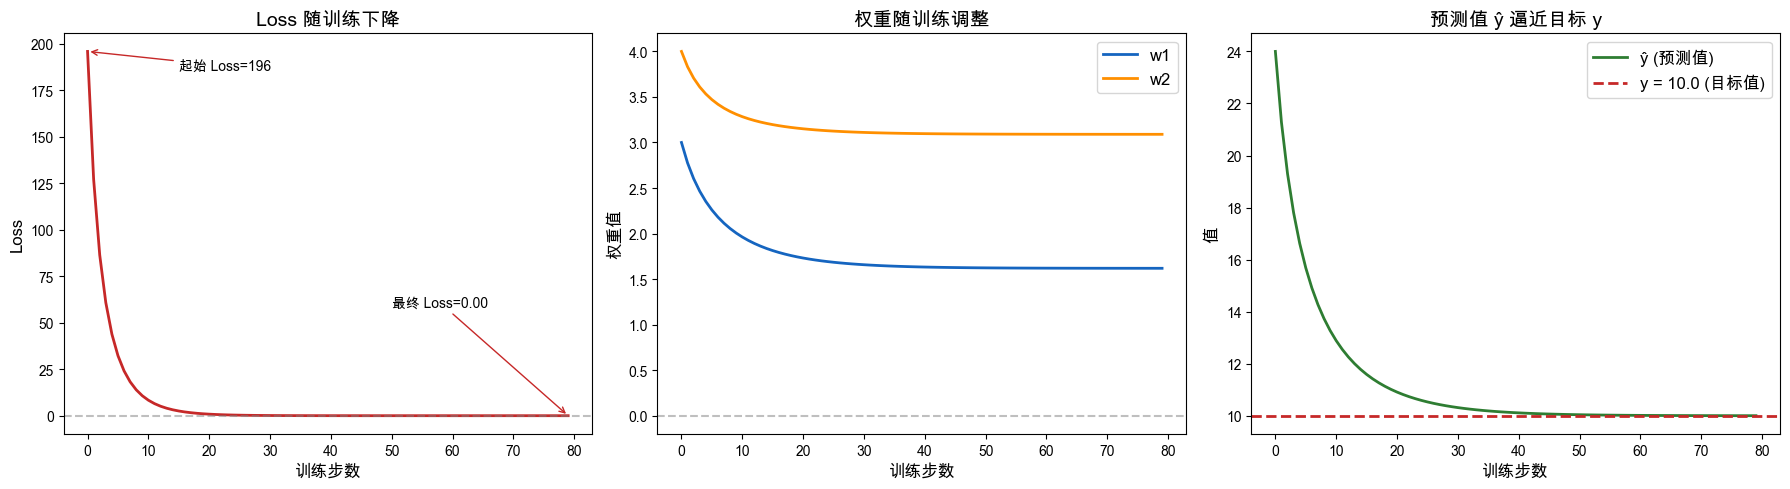

In [7]:
# ============================================================
# 可视化 1：Loss 随训练步数的变化
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- 图1: Loss 曲线 ---
axes[0].plot(history['loss'], color='#C62828', linewidth=2)
axes[0].set_xlabel('训练步数', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss 随训练下降', fontsize=14, fontweight='bold')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
# 标注起点和终点
axes[0].annotate(f'起始 Loss={history["loss"][0]:.0f}',
                 xy=(0, history['loss'][0]), fontsize=10,
                 xytext=(15, history['loss'][0]-10),
                 arrowprops=dict(arrowstyle='->', color='#C62828'))
axes[0].annotate(f'最终 Loss={history["loss"][-1]:.2f}',
                 xy=(len(history['loss'])-1, history['loss'][-1]), fontsize=10,
                 xytext=(len(history['loss'])-30, history['loss'][0]*0.3),
                 arrowprops=dict(arrowstyle='->', color='#C62828'))

# --- 图2: 权重变化轨迹 ---
axes[1].plot(history['w1'], label='w1', color='#1565C0', linewidth=2)
axes[1].plot(history['w2'], label='w2', color='#FF8F00', linewidth=2)
axes[1].set_xlabel('训练步数', fontsize=12)
axes[1].set_ylabel('权重值', fontsize=12)
axes[1].set_title('权重随训练调整', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# --- 图3: 预测值逼近目标 ---
axes[2].plot(history['y_hat'], color='#2E7D32', linewidth=2, label='ŷ (预测值)')
axes[2].axhline(y=y, color='#C62828', linestyle='--', linewidth=2, label=f'y = {y} (目标值)')
axes[2].set_xlabel('训练步数', fontsize=12)
axes[2].set_ylabel('值', fontsize=12)
axes[2].set_title('预测值 ŷ 逼近目标 y', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=12)

plt.tight_layout()
plt.show()

---
## 第五步：用 PyTorch 自动求导验证我们的手动计算

PyTorch 的 `autograd` 可以自动完成反向传播。让我们验证它和手动计算的结果完全一致。

In [8]:
# ============================================================
# PyTorch 自动求导 —— 验证手动计算的梯度
# ============================================================
x_t  = torch.tensor(2.0)
y_t  = torch.tensor(10.0)
w1_t = torch.tensor(3.0, requires_grad=True)  # requires_grad=True 告诉 PyTorch 追踪梯度
w2_t = torch.tensor(4.0, requires_grad=True)

# 正向传播（和手动计算完全一样）
h_t     = w1_t * x_t
y_hat_t = w2_t * h_t
loss_t  = (y_hat_t - y_t) ** 2

# 反向传播 —— 一行代码！PyTorch 自动用链式法则算出所有梯度
loss_t.backward()

print("========== PyTorch 自动求导 vs 手动计算 ==========")
print(f"∂Loss/∂w1:  PyTorch = {w1_t.grad.item():.1f},  手动 = {224.0:.1f}  ✅")
print(f"∂Loss/∂w2:  PyTorch = {w2_t.grad.item():.1f},  手动 = {168.0:.1f}  ✅")
print()
print("💡 完全一致！这证明我们手动用链式法则计算的梯度是正确的。")
print("   PyTorch 的 .backward() 内部做的就是我们上面手动算的那些步骤。")

========== PyTorch 自动求导 vs 手动计算 ==========
∂Loss/∂w1:  PyTorch = 224.0,  手动 = 224.0  ✅
∂Loss/∂w2:  PyTorch = 168.0,  手动 = 168.0  ✅

💡 完全一致！这证明我们手动用链式法则计算的梯度是正确的。
   PyTorch 的 .backward() 内部做的就是我们上面手动算的那些步骤。


---
## 总结

| 概念 | 一句话解释 |
|------|------------|
| **正向传播** | 从输入到输出，逐层计算预测值和 Loss |
| **链式法则** | 把「远处变量对 Loss 的影响」拆成一连串「相邻变量之间的局部导数」相乘 |
| **反向传播** | 从 Loss 出发，利用链式法则**从后往前**逐层计算每个参数的梯度 |
| **梯度下降** | 用梯度指示的方向，**反方向**微调权重，使 Loss 一步步减小 |

**整个训练过程就是不断重复：正向传播 → 反向传播 → 梯度下降 → 正向传播 → ...**

```
          正向传播                反向传播              梯度下降
x → w1·x → h → w2·h → ŷ → Loss → ∂L/∂ŷ → ∂L/∂w2 → w2 -= lr·∂L/∂w2
                                         → ∂L/∂h  → ∂L/∂w1 → w1 -= lr·∂L/∂w1
```